In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [2]:
ethereum = pd.read_csv('/kaggle/input/ethereum-2/ETH-USD-2.csv', index_col='Date')
ethereum

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-01,141.465485,142.733994,140.737564,141.830322,141.830322,4611999536
2019-04-02,141.839523,165.226822,141.636459,163.961746,163.961746,9826645698
2019-04-03,164.008636,178.322052,157.322144,161.458801,161.458801,10622456246
2019-04-04,161.431763,164.929214,155.241104,158.052536,158.052536,7953123529
2019-04-05,158.020004,167.220383,157.443954,165.514847,165.514847,7531316908
...,...,...,...,...,...,...
2024-03-28,3500.216064,3609.705322,3465.332275,3561.293945,3561.293945,16419674157
2024-03-29,3561.011719,3583.701416,3475.725586,3511.806152,3511.806152,12712701619
2024-03-30,3511.827637,3566.084473,3489.902100,3507.944336,3507.944336,9389066783


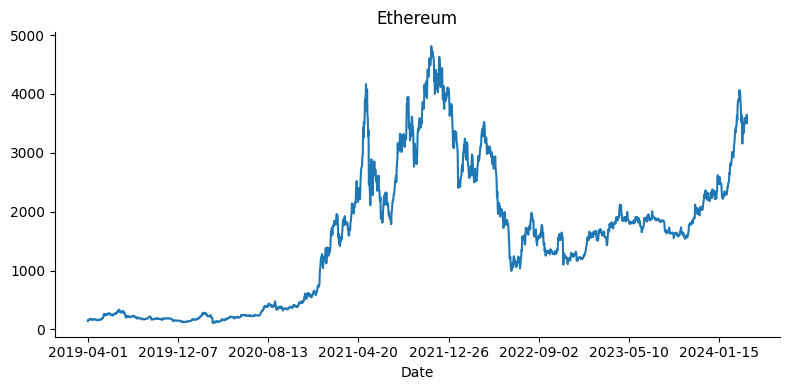

In [3]:
ethereum['Close'].plot(kind='line', figsize=(8, 4), title='Ethereum')
plt.tight_layout()
plt.gca().spines[['top', 'right']].set_visible(False)

In [4]:
def Dataset(data, split=0.8):
    """Function to split the data"""

    data['y'] = data['Close']

    x = data.iloc[:, :6].values
    y = data.iloc[:, 6].values

    split = int(data.shape[0]* split)
    train_x, test_x = x[: split, :], x[split - 20:, :]
    train_y, test_y = y[: split, ], y[split - 20: , ]

    # print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
    # print(f'testX: {test_x.shape} testY: {test_y.shape}')

    x_scaler = MinMaxScaler(feature_range = (0, 1))
    y_scaler = MinMaxScaler(feature_range = (0, 1))

    train_x = x_scaler.fit_transform(train_x)
    test_x = x_scaler.transform(test_x)

    train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
    test_y = y_scaler.transform(test_y.reshape(-1, 1))

    return train_x, test_x, train_y, test_y

In [5]:
ethereum_train_x, ethereum_test_x, ethereum_train_y, ethereum_test_y = Dataset(ethereum)
print(f'trainX: {ethereum_train_x.shape} trainY: {ethereum_train_y.shape}')
print(f'testX: {ethereum_test_x.shape} testY: {ethereum_test_y.shape}')

trainX: (1462, 6) trainY: (1462, 1)
testX: (386, 6) testY: (386, 1)


In [6]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        )

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar


In [7]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(ethereum_train_x).float()), batch_size = 128, shuffle = False)
model = VAE([6, 400, 400, 400, 10], 10)

[1/300] Loss: 417.9039430618286
[2/300] Loss: 390.82844829559326
[3/300] Loss: 365.83587646484375
[4/300] Loss: 344.05071544647217
[5/300] Loss: 328.8708257675171
[6/300] Loss: 323.54253005981445
[7/300] Loss: 326.9771919250488
[8/300] Loss: 330.2842073440552
[9/300] Loss: 324.8374195098877
[10/300] Loss: 313.1388740539551
[11/300] Loss: 302.32001876831055
[12/300] Loss: 295.58713817596436
[13/300] Loss: 292.1310787200928
[14/300] Loss: 290.243688583374
[15/300] Loss: 288.55703258514404
[16/300] Loss: 286.1344356536865
[17/300] Loss: 282.4678649902344
[18/300] Loss: 277.53676319122314
[19/300] Loss: 272.1165027618408
[20/300] Loss: 267.23609828948975
[21/300] Loss: 263.64473056793213
[22/300] Loss: 261.14090061187744
[23/300] Loss: 258.60572147369385
[24/300] Loss: 254.53058052062988
[25/300] Loss: 248.42494678497314
[26/300] Loss: 241.3482484817505
[27/300] Loss: 234.929594039917
[28/300] Loss: 230.66348838806152
[29/300] Loss: 229.0065402984619
[30/300] Loss: 229.01826667785645
[31/3

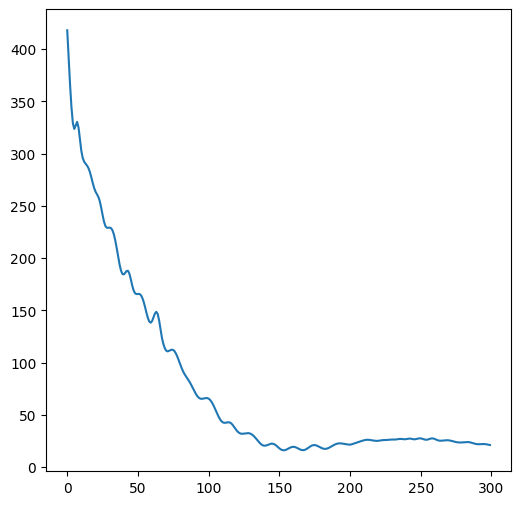

In [8]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 300
learning_rate = 0.00003
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs)
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(6, 6))
plt.plot(hist)

In [9]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(ethereum_train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(ethereum_test_x).float().to(device))

In [10]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [11]:
ethereum_train_x = np.concatenate((ethereum_train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
ethereum_test_x = np.concatenate((ethereum_test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [12]:
e_train_x_slide, e_train_y_slide, e_train_y_gan = sliding_window(ethereum_train_x, ethereum_train_y, 3)
e_test_x_slide, e_test_y_slide, e_test_y_gan = sliding_window(ethereum_test_x, ethereum_test_y, 3)
print(f'train_x: {e_train_x_slide.shape} train_y: {e_train_y_slide.shape} train_y_gan: {e_train_y_gan.shape}')
print(f'test_x: {e_test_x_slide.shape} test_y: {e_test_y_slide.shape} test_y_gan: {e_test_y_gan.shape}')

train_x: torch.Size([1459, 3, 16]) train_y: torch.Size([1459, 1]) train_y_gan: torch.Size([1459, 4, 1])
test_x: torch.Size([383, 3, 16]) test_y: torch.Size([383, 1]) test_y_gan: torch.Size([383, 4, 1])


In [13]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out_6 = self.linear_3(out_5)
        return out_6

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 5, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 5, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 5, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.linear2 = nn.Linear(220, 220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x =  conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out = self.linear3(out_2)
        return out

In [14]:
from ast import Break
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 128
learning_rate = 0.000115
num_epochs = 100
critic_iterations = 5
weight_clip = 0.01

trainDataloader = DataLoader(TensorDataset(e_train_x_slide, e_train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(16).to(device)
modelD = Discriminator().to(device)

optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
flag = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)
        critic_real = modelD(y)
        critic_fake = modelD(fake_data)
        lossD = -(torch.mean(critic_real) - torch.mean(critic_fake))
        modelD.zero_grad()
        lossD.backward(retain_graph = True)
        optimizerD.step()

        output_fake = modelD(fake_data)
        lossG = -torch.mean(output_fake)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()

        loss_D.append(lossD.item())
        loss_G.append(lossG.item())

        if np.abs(lossD.item()) < 1e-9 or np.abs(lossG.item()) < 1e-9:
          flag = 1
          break
            
    histG[epoch] = sum(loss_G)
    histD[epoch] = sum(loss_D)
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

    if flag == 1:
      break

[1/100] LossD: -0.000666031613945961 LossG:-0.2005807738751173
[2/100] LossD: -0.0026543578132987022 LossG:-0.18202272150665522
[3/100] LossD: -0.004352514632046223 LossG:-0.15882108639925718
[4/100] LossD: -0.0055821677669882774 LossG:-0.1327707851305604
[5/100] LossD: -0.006835516542196274 LossG:-0.10793979372829199
[6/100] LossD: -0.007679302711039782 LossG:-0.08314626850187778
[7/100] LossD: -0.007753927959129214 LossG:-0.05606777290813625
[8/100] LossD: -0.007311774184927344 LossG:-0.03079394856467843
[9/100] LossD: -0.005936992587521672 LossG:-0.01187271805247292
[10/100] LossD: -0.0038584147405344993 LossG:0.005194780904275831
[11/100] LossD: -0.0016011727275326848 LossG:0.019176848349161446
[12/100] LossD: 0.00016296422109007835 LossG:0.03551756986416876
[13/100] LossD: 0.0012317553628236055 LossG:0.04306064988486469
[14/100] LossD: 0.0016872880514711142 LossG:0.05197926424443722
[15/100] LossD: 0.0012846579775214195 LossG:0.05509061040356755
[16/100] LossD: 0.00064169638790190

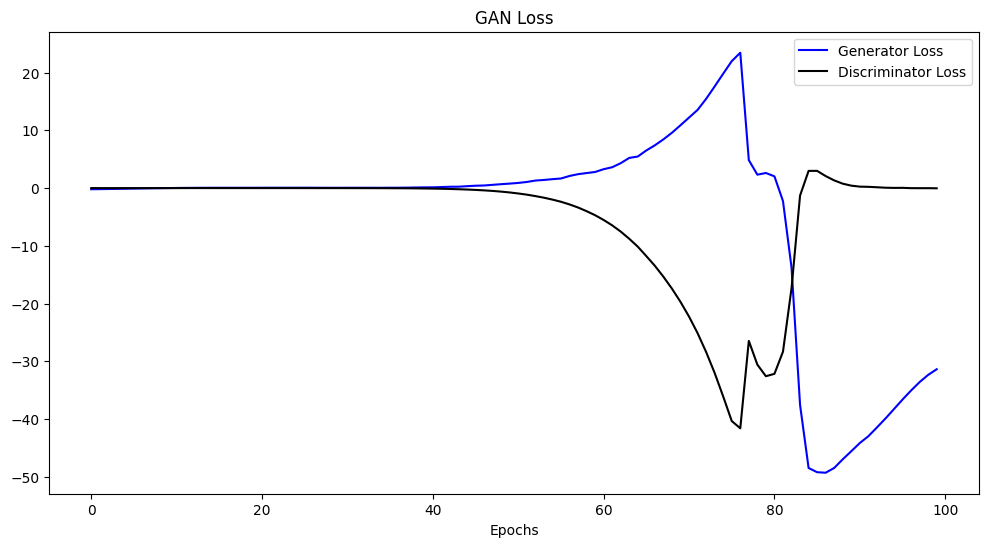

In [2]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Epochs')
plt.legend(loc = 'upper right')

In [16]:
y_scaler = MinMaxScaler(feature_range = (0, 1))
dummy = y_scaler.fit_transform(e_train_y_slide.reshape(-1, 1))

modelG.eval()
pred_y_train = modelG(e_train_x_slide.to(device))
pred_y_test = modelG(e_test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(e_train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = y_scaler.inverse_transform(e_test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

In [17]:
y_train_true = y_train_true + 0.000001
y_train_pred = y_train_pred + 0.000001
y_test_true = y_test_true + 0.000001
y_test_pred = y_test_pred + 0.000001

Training dataset RMSE:0.039176202123907794
Training dataset MAPE:8.793037802421868


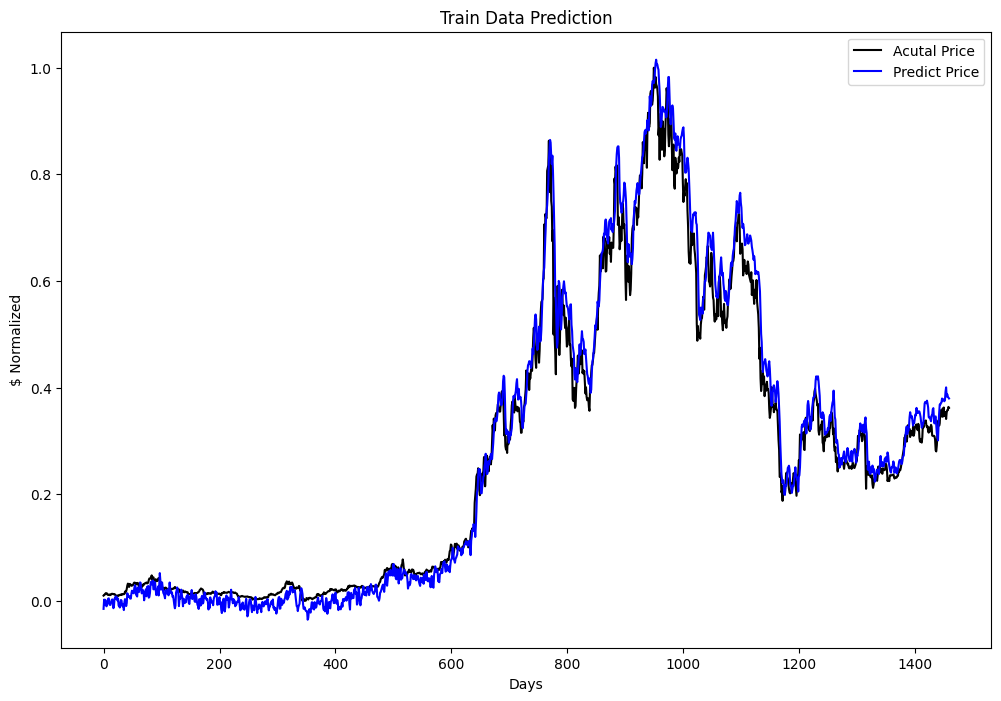

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('Train Data Prediction')
plt.ylabel('$ Normalized')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')
mape = np.mean(np.abs(y_train_pred - y_train_true)/np.abs(y_train_true))
print(f'Training dataset MAPE:{mape}')

Testing dataset RMSE:0.03825794573067061
Testing dataset MAPE:0.08205526294958074


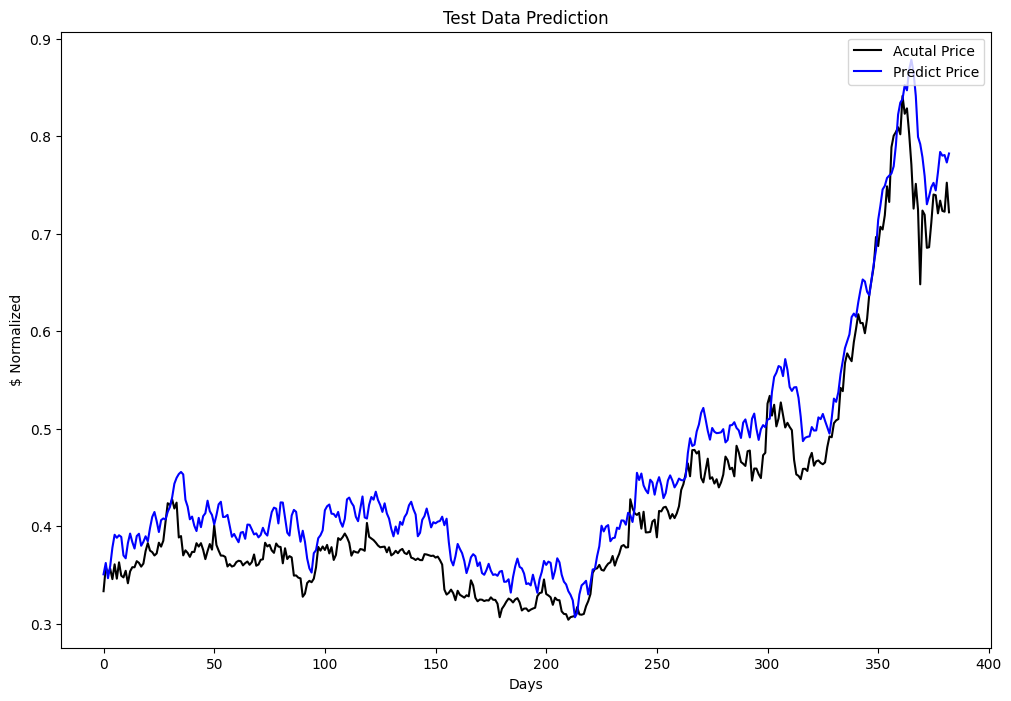

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('Test Data Prediction')
plt.ylabel('$ Normalized')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')
mape = np.mean(np.abs(y_test_pred - y_test_true)/np.abs(y_test_true))
print(f'Testing dataset MAPE:{mape}')